# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

# 0. Import Libraries and Define Constants

In [31]:
import pandas as pd
import numpy as np
import essentia
import essentia.standard as estd
from essentia.standard import *
import matplotlib.pyplot as plt
from IPython.display import display, Audio
from pylab import plot, show, figure, imshow
%matplotlib inline

In [38]:
TARGET_SOUND_PATH_BREAK = '194817__csum__amen-break-mashed-164bpm.wav'  # Filename of the target audio we'll reconstruct
TARGET_SOUND_PATH_PIANO = '486472__tkky__piano-chopped-edited.wav'      # Filename of the target audio we'll reconstruct

DATAFRAME_FILENAME_BREAK = 'dataframe_break.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME_BREAK = 'dataframe_source_break.csv'  # DataFrame file where to store the results of our analysis
DATAFRAME_TARGET_FILE_FILENAME_BREAK = 'dataframe_target_break.csv'  # DataFrame file where to store the analysis results of the target audio

DATAFRAME_FILENAME_PIANO = 'dataframe_piano.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME_PIANO = 'dataframe_source_piano.csv'  # DataFrame file where to store the results of our analysis
DATAFRAME_TARGET_FILE_FILENAME_PIANO = 'dataframe_target_piano.csv'  # DataFrame file where to store the analysis results of the target audio

# 1. Segment Audio with Onset Detection Function
The initial idea was to compute beats for segmentation, but after experimentation, onset detection was chosen due to potential loss of audio events between beats.

## 1.1. Compute Beats for Comparison(not used)

In [39]:
def compute_beats(audio_path):
    upper_b = 44100 * 3
    # load audio
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    audio = audio[:upper_b]
    # extract beats
    beat_tracker_algo = estd.BeatTrackerDegara()
    beat_positions = beat_tracker_algo(audio)
    beat_positions = [int(round(position * 44100)) for position in beat_positions]
    
    # plot beat locations for first 3 secs
    plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default

    plot(audio[:upper_b])
    for beat_pos in beat_positions:
        plt.axvline(x=beat_pos, color='red')

    plt.title("Audio waveform and the estimated beat positions")   

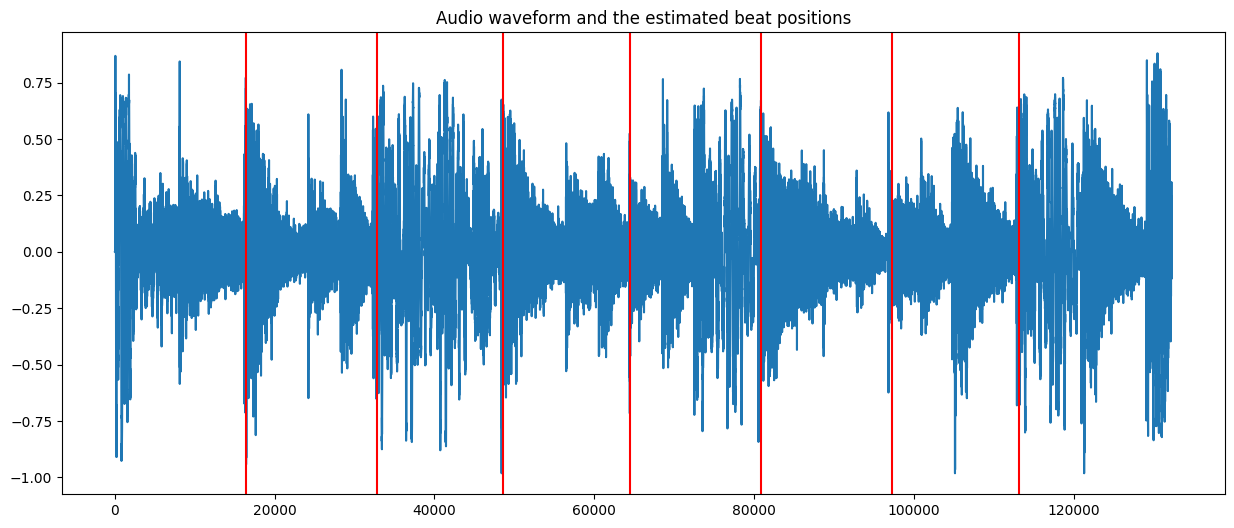

In [40]:
# demo of beat segmentation function
compute_beats(TARGET_SOUND_PATH_BREAK)

## 1.2. Comparison among 3 Onset Detection Functions
We are comparing three onset detction functions from the Essentia library to determine the most effective performance for our amen break-beat and piano sample.<br><br>
**Observation:** From the analysis below, we found that the complex onset function yields the best performance for beat-break segmentation, while the hfc onset detection function is the best for piano segmentation.

In [41]:
def plot_audio_onsets(audio_path, onsets, title):
    upper_b = 44100 * 3 #bound to 3secs
    target_audio = estd.MonoLoader(filename=audio_path)()
    audio = target_audio[:upper_b]
    
    plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default
    plot(audio[:upper_b]) #plot first 3secs of audio
              
    # plotting first 3 seconds
    onsets_filter =[i for i in onsets if i <= upper_b]
    for onset in onsets_filter:
        plt.axvline(x=onset, color='red')

    plt.title("Audio waveform and the estimated {} onset positions".format(title)) 
    plt.show()

In [52]:
def compute_onsets_complex_hfc_specflux(audio_path):
    target_audio = estd.MonoLoader(filename=audio_path)()
    audio = target_audio
    # Phase 1: compute the onset detection function
    # The OnsetDetection algorithm provides various onset detection functions. Let’s use two of them.
    od1 = OnsetDetection(method='hfc')
    od2 = OnsetDetection(method='complex')
    # Do the other algorithms and pooling to store the results
    w = Windowing(type = 'hann')
    fft = FFT() # this gives us a complex FFT
    c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
    pool = essentia.Pool()
    # Compute onset detection functions.
    for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features.hfc', od1(mag, phase))
        pool.add('features.complex', od2(mag, phase))
    # Phase 2: compute the actual onsets locations
    onsets = Onsets()
    onsets_complex = onsets(essentia.array([ pool['features.complex'] ]), [ 1 ]) * 44100
    onsets_hfc = onsets(essentia.array([ pool['features.hfc'] ]), [ 1 ]) * 44100

    # Compute onset function of spectral flux
    superflux_extractor = SuperFluxExtractor(threshold=0.04)
    onsets_specflux = superflux_extractor(audio) * 44100
    onsets_specflux = list(map(int, onsets_specflux))
    return onsets_complex, onsets_hfc, onsets_specflux

### 1.2.1. Break-beat Onset Detection Functions

[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


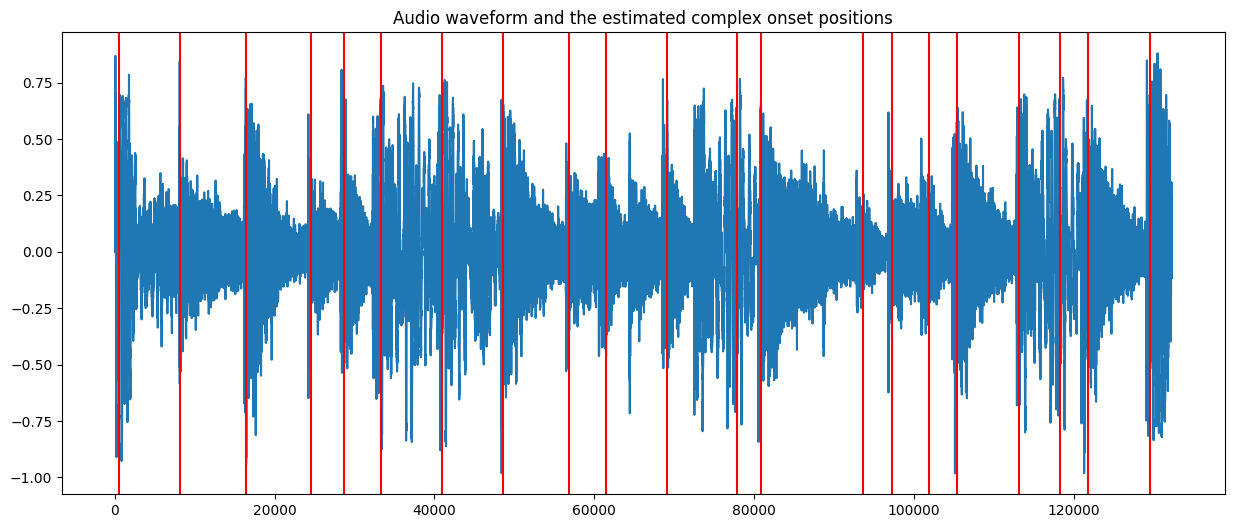

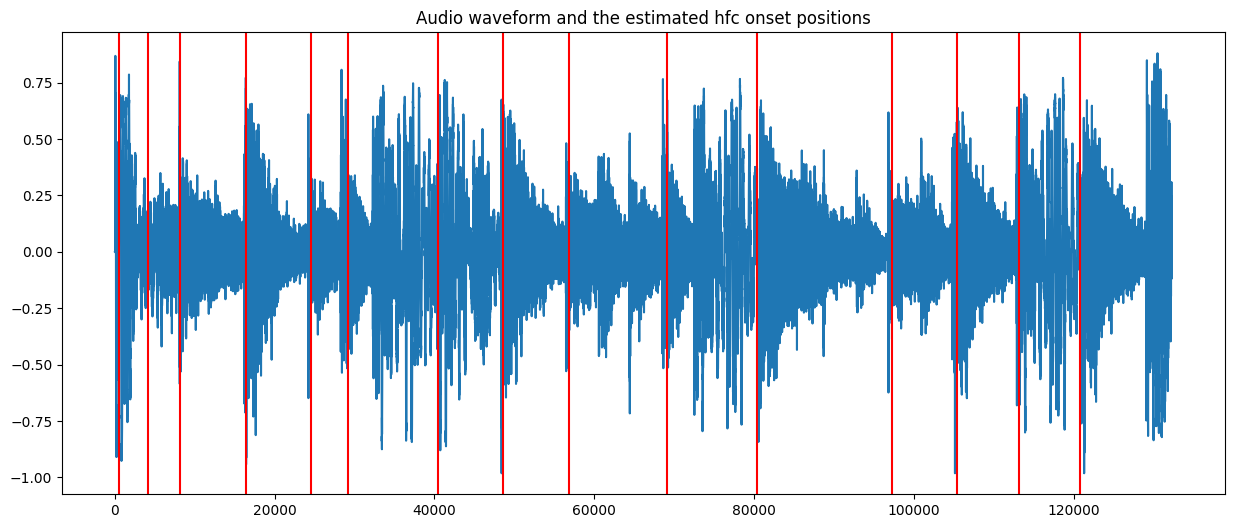

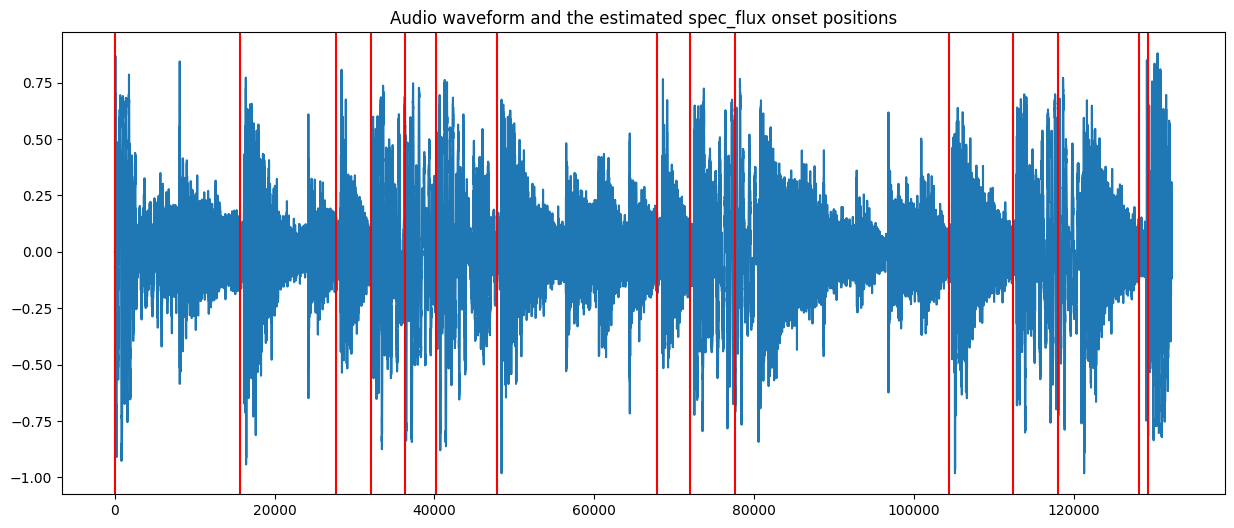

In [53]:
onsets_complex, onsets_hfc, onsets_specflux = compute_onsets_complex_hfc_specflux(TARGET_SOUND_PATH_BREAK)

plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_complex, 'complex')
plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_hfc, 'hfc')
plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_specflux, 'spec_flux')

### 1.2.2. Piano Onset Detection Functions

[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


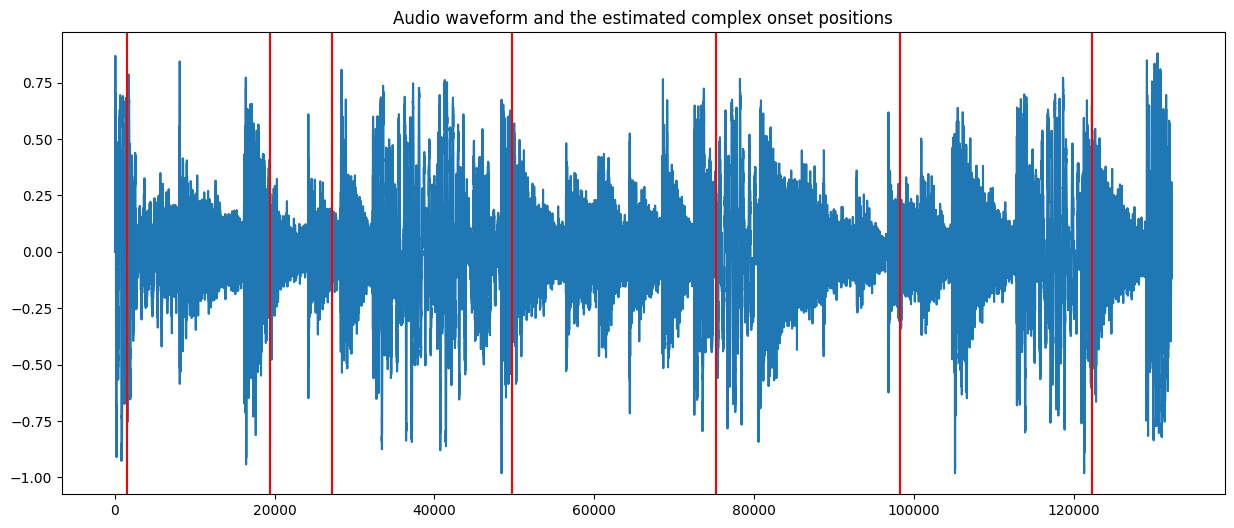

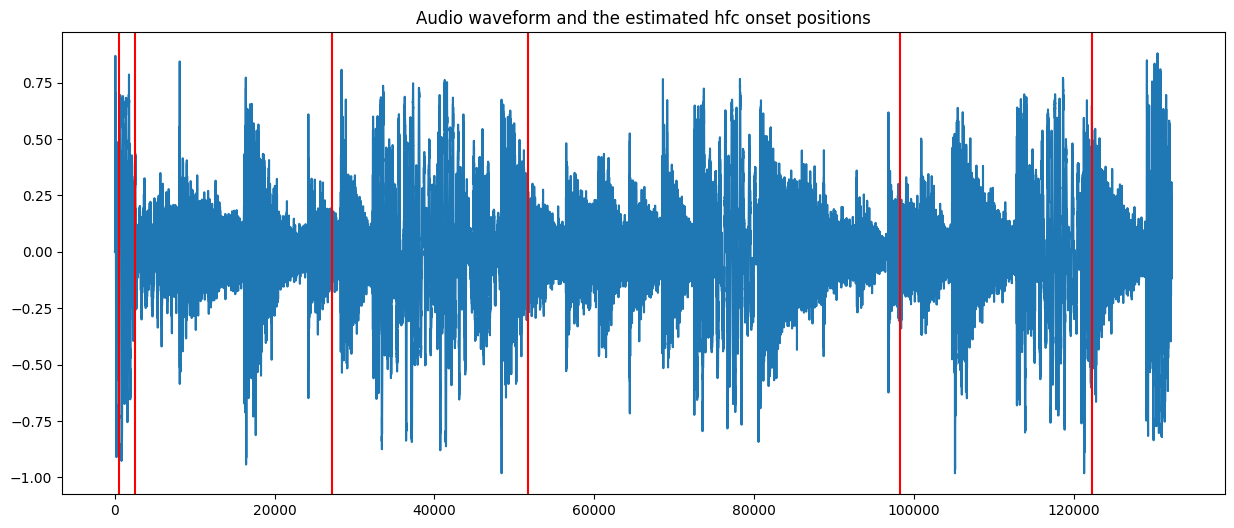

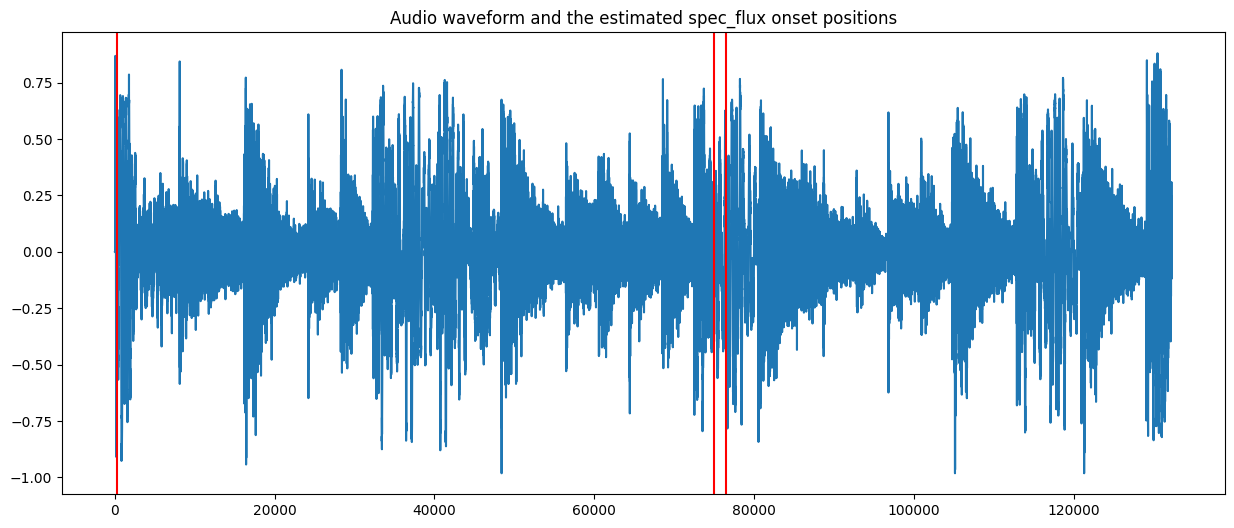

In [54]:
onsets_complex, onsets_hfc, onsets_specflux = compute_onsets_complex_hfc_specflux(TARGET_SOUND_PATH_PIANO)

plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_complex, 'complex')
plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_hfc, 'hfc')
plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_specflux, 'spec_flux')

# 2. Analyze Source Collection

In [63]:
def analyze_sound_for_onset(audio_path, onsets=None, audio_id=None, melodic=False):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    
    onset_i = np.arange(0, len(onsets)-1)
    for i in onset_i:
        fstart = int(onsets[i])
        fend = int(onsets[i+1]) 
        
        if (fend-fstart) % 2 != 0: frame = audio[fstart:fend+1]
        else: frame = audio[fstart:fend]
     
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, i),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        w_algo = estd.Windowing(type = 'hann')
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        # Extract other features here and add to 'frame_output' dictionary

        # (1) compute temperal aspects, the atack
        a_algo = estd.LogAttackTime()
        attack = a_algo(frame)
        a_time = attack[0]
        a_start = attack[1]
        a_stop = attack[2]
        frame_output.update({'attack_time' : a_time})
        frame_output.update({'attack_start' : a_start})
        frame_output.update({'attack_stop' : a_stop})
        
        # Add frame analysis results to output
        analysis_output.append(frame_output)
        
        # Add frame analysis results to output
        analysis_output.append(frame_output)
        
        # (2) Compute zero crossing rate to detect changes in nosiy-ness in the signal
        z_algo = ZeroCrossingRate()
        zc_rate = z_algo(frame)
        frame_output.update({'zero_crossing' : zc_rate})
        
        # (3) Compute Spectral centroid in time domain
        sct_algo = SpectralCentroidTime()
        spec_cent = sct_algo(frame)
        frame_output.update({'spec_centroid': spec_cent})
        
        # (4) if we are considering a melodic, piece, also compute pitch
        if melodic:
            #print('melodic true')
            pitch_algo = PitchMelodia()
            pitchcontorsep_algo = PitchContourSegmentation()
            pitch_contor, pitch_confidence = pitch_algo(frame)
            onset, duration, pitch = pitchcontorsep_algo(pitch_contor, frame)
            if len(pitch) >= 1: pitch = pitch[0]
            else: pitch = 0
            frame_output.update({'pitch': pitch})
        
    return analysis_output

## 2.1. Amen Break Beat

Analyzing target sound 194817__csum__amen-break-mashed-164bpm.wav


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


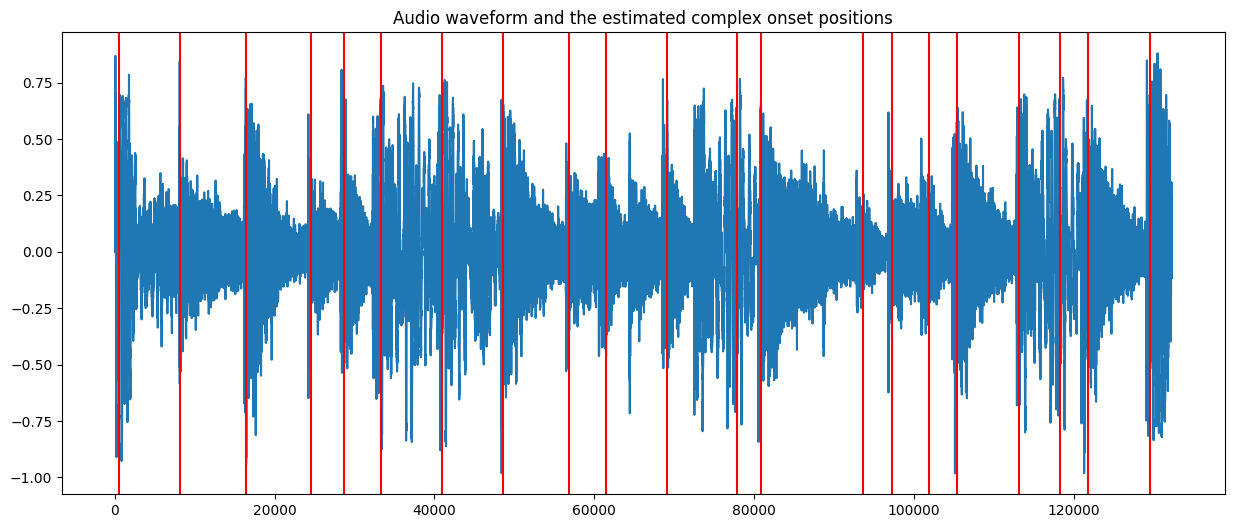

[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4097) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4097) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2306) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Saved target dataframe with 306 entries! dataframe_target_break.csv


,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,attack_time,attack_start,attack_stop,zero_crossing,spec_centroid
0,None,None_f0,194817__csum__amen-break-mashed-164bpm.wav,512,8192,0.008306,-669.507812,85.322327,-11.203526,106.439491,...,-0.328415,4.613068,-8.762491,4.249525,-10.735210,-1.554181,0.000045,0.027959,0.056250,950.996216
1,None,None_f0,194817__csum__amen-break-mashed-164bpm.wav,512,8192,0.008306,-669.507812,85.322327,-11.203526,106.439491,...,-0.328415,4.613068,-8.762491,4.249525,-10.735210,-1.554181,0.000045,0.027959,0.056250,950.996216
2,None,None_f1,194817__csum__amen-break-mashed-164bpm.wav,8192,16384,0.002464,-682.918152,20.526302,-26.032373,87.041885,...,-4.273056,-2.984608,-11.040848,-3.326866,-15.726780,-0.731738,0.000249,0.185714,0.161499,3583.469482
3,None,None_f1,194817__csum__amen-break-mashed-164bpm.wav,8192,16384,0.002464,-682.918152,20.526302,-26.032373,87.041885,...,-4.273056,-2.984608,-11.040848,-3.326866,-15.726780,-0.731738,0.000249,0.185714,0.161499,3583.469482
4,None,None_f2,194817__csum__amen-break-mashed-164bpm.wav,16384,24576,0.004289,-619.264893,80.228516,-46.722527,55.876377,...,-9.194195,9.052788,4.594311,5.912846,-12.209896,-5.000000,0.000000,0.000000,0.131226,2609.977783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,None,None_f150,194817__csum__amen-break-mashed-164bpm.wav,1016832,1021440,0.004406,-618.652527,61.413612,-44.838238,58.086834,...,-14.715389,0.446739,-10.231796,2.501534,-18.534874,-1.082146,0.000091,0.082857,0.135417,2519.853516
302,None,None_f151,194817__csum__amen-break-mashed-164bpm.wav,1021440,1025535,0.004971,-605.080383,74.900208,-40.484821,58.342072,...,-17.031109,-2.903736,-11.648134,3.059963,-14.648935,-1.157159,0.000204,0.069841,0.135254,2436.389404
303,None,None_f151,194817__csum__amen-break-mashed-164bpm.wav,1021440,1025535,0.004971,-605.080383,74.900208,-40.484821,58.342072,...,-17.031109,-2.903736,-11.648134,3.059963,-14.648935,-1.157159,0.000204,0.069841,0.135254,2436.389404
304,None,None_f152,194817__csum__amen-break-mashed-164bpm.wav,1025535,1029632,0.005331,-594.901794,78.412819,-39.555573,58.020088,...,-17.709431,-3.546654,-12.286970,2.653503,-13.854399,-1.168187,0.000544,0.068435,0.132260,2441.113770


,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,attack_time,attack_start,attack_stop,zero_crossing,spec_centroid
count,3.060000e+02,3.060000e+02,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,...,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,5.103468e+05,5.170731e+05,0.007133,-640.397949,71.169830,-20.615917,79.663734,-2.329749,16.897053,-13.337662,...,-3.987262,1.269712,-6.347714,0.321240,-11.858258,-1.863906,0.000627,0.055655,0.104366,1983.064875
std,3.012462e+05,3.012767e+05,0.004103,31.611860,32.120926,26.780512,20.735779,15.660761,13.461576,12.189634,...,8.873407,5.989803,6.307111,5.426312,5.082276,1.057802,0.001151,0.058899,0.052014,997.964816
min,5.120000e+02,8.192000e+03,0.002079,-707.304688,6.991293,-67.421494,45.850788,-25.480795,-8.881413,-42.279861,...,-20.675415,-17.432983,-19.705360,-14.685024,-25.519978,-5.000000,0.000000,0.000000,0.011502,376.765442
25%,2.426880e+05,2.503680e+05,0.003918,-663.510254,46.955807,-44.140747,62.299347,-16.260132,5.893806,-22.335962,...,-10.582247,-3.168755,-11.570158,-2.993969,-14.768509,-2.527167,0.000000,0.004580,0.053850,968.964783
50%,5.007360e+05,5.084160e+05,0.005434,-637.743286,70.661362,-26.708881,69.231483,-5.628544,17.840069,-14.358517,...,-4.273056,0.753593,-5.557598,0.224209,-11.660879,-1.259727,0.000113,0.055669,0.129427,2234.259033
75%,7.680000e+05,7.751680e+05,0.009823,-622.290588,86.805313,6.387814,100.856483,12.692028,28.926838,-2.757202,...,1.921097,6.040260,-2.319960,4.613432,-9.547775,-1.092745,0.000612,0.080839,0.143066,2738.137695
max,1.025535e+06,1.029632e+06,0.018181,-527.583374,142.546112,34.369568,122.784042,30.553467,41.634693,7.752880,...,18.022491,17.427742,10.765488,12.162596,3.089470,-0.583514,0.005533,0.260907,0.184326,3844.546631


In [73]:
# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH_BREAK))

# compute onsets first
onsets_complex, _, _ = compute_onsets_complex_hfc_specflux(TARGET_SOUND_PATH_BREAK)
plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_complex, 'complex')
# split and analyse sounds
target_analysis = analyze_sound_for_onset(TARGET_SOUND_PATH_BREAK, onsets_complex)

df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME_BREAK)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME_BREAK))

display(df_target)    # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

## 2.2. Piano

Analyzing target sound 486472__tkky__piano-chopped-edited.wav


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


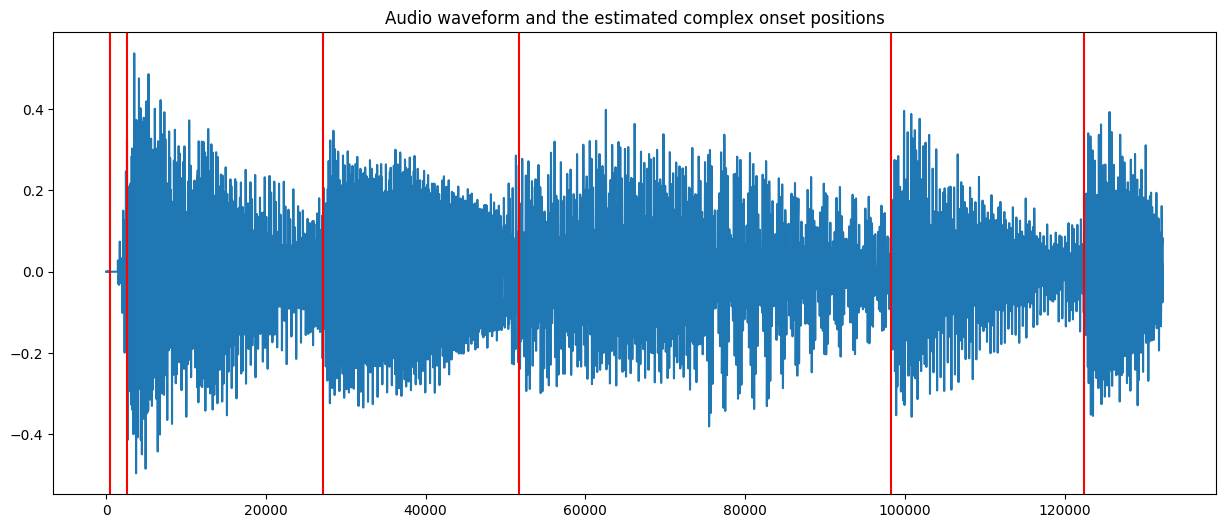

[   INFO   ] TriangularBands: input spectrum size (12289) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12289) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (23298) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12033) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12289) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12033) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12033) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Saved target dataframe with 80 entries! dataframe_target_piano.csv


[   INFO   ] TriangularBands: input spectrum size (12033) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (11521) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10753) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_9,mfcc_10,mfcc_11,mfcc_12,attack_time,attack_start,attack_stop,zero_crossing,spec_centroid,pitch
0,None,None_f0,486472__tkky__piano-chopped-edited.wav,512,2560,0.001485,-884.181702,201.854218,57.290298,20.091789,...,-1.318981,-3.067871,-6.657578,-11.762085,-1.748464,0.026803,0.044649,0.397949,469.891327,0.0
1,None,None_f0,486472__tkky__piano-chopped-edited.wav,512,2560,0.001485,-884.181702,201.854218,57.290298,20.091789,...,-1.318981,-3.067871,-6.657578,-11.762085,-1.748464,0.026803,0.044649,0.397949,469.891327,0.0
2,None,None_f1,486472__tkky__piano-chopped-edited.wav,2560,27136,0.002438,-1019.467163,277.915192,125.002563,-3.391510,...,5.643284,15.581421,12.266018,-1.032894,-1.676891,0.000748,0.021791,0.022868,502.141144,50.0
3,None,None_f1,486472__tkky__piano-chopped-edited.wav,2560,27136,0.002438,-1019.467163,277.915192,125.002563,-3.391510,...,5.643284,15.581421,12.266018,-1.032894,-1.676891,0.000748,0.021791,0.022868,502.141144,50.0
4,None,None_f2,486472__tkky__piano-chopped-edited.wav,27136,51711,0.002540,-1051.508789,249.490814,129.207275,17.211700,...,0.582973,14.439125,18.370525,9.909546,-1.733814,0.002562,0.021020,0.019328,430.456329,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,None,None_f37,486472__tkky__piano-chopped-edited.wav,1084928,1110016,0.001634,-1054.537842,248.582458,134.313904,24.405518,...,-13.149475,-10.126686,-2.216343,3.437225,-1.611820,0.001542,0.025986,0.014908,321.675232,52.0
76,None,None_f38,486472__tkky__piano-chopped-edited.wav,1110016,1133056,0.000991,-1063.714844,236.042786,123.703064,18.008759,...,-14.754410,-7.759613,3.624798,9.834694,-2.544068,0.000476,0.003333,0.016493,348.036102,48.0
77,None,None_f38,486472__tkky__piano-chopped-edited.wav,1110016,1133056,0.000991,-1063.714844,236.042786,123.703064,18.008759,...,-14.754410,-7.759613,3.624798,9.834694,-2.544068,0.000476,0.003333,0.016493,348.036102,48.0
78,None,None_f39,486472__tkky__piano-chopped-edited.wav,1133056,1154560,0.001402,-1068.404419,233.694672,129.419189,26.720352,...,-16.512604,-15.097771,-6.406429,2.384830,-2.189594,0.001066,0.007528,0.014788,321.550232,64.0


,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,mfcc_9,mfcc_10,mfcc_11,mfcc_12,attack_time,attack_start,attack_stop,zero_crossing,spec_centroid,pitch
count,8.000000e+01,8.000000e+01,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,5.462271e+05,5.750783e+05,0.001578,-1044.396240,247.048004,118.997581,12.854631,-27.312237,-19.902191,-6.940662,...,-8.679655,-3.901391,-2.357521,-5.325591,-1.749953,0.002570,0.049087,0.024423,346.074247,50.950000
std,3.505443e+05,3.519486e+05,0.000474,30.543089,14.713366,17.253607,17.312584,11.400830,10.122092,6.938867,...,10.421355,10.827230,10.293579,10.590652,0.664017,0.005570,0.092700,0.060369,101.390049,14.476432
min,5.120000e+02,2.560000e+03,0.000936,-1078.776489,201.854218,57.290298,-18.650940,-59.509346,-41.205574,-21.849983,...,-31.645767,-26.600628,-31.281445,-33.858574,-3.644439,0.000000,0.000227,0.006029,152.609650,0.000000
25%,2.369280e+05,2.787840e+05,0.001306,-1061.396240,237.832977,113.318237,4.961418,-32.175453,-27.722816,-13.275921,...,-15.193958,-12.138985,-9.764845,-11.421886,-2.005651,0.000000,0.010040,0.011846,274.412712,48.000000
50%,5.442560e+05,5.675520e+05,0.001464,-1049.141785,248.241562,124.165527,17.533524,-25.924755,-18.488213,-7.557755,...,-8.166039,-3.633400,0.094727,-2.307819,-1.678535,0.000590,0.024864,0.014500,341.891068,52.000000
75%,8.267520e+05,8.518400e+05,0.001858,-1035.922577,255.211388,128.548553,26.006161,-19.820219,-13.717640,-0.406853,...,-0.888847,3.585096,5.428152,1.019602,-1.430459,0.002200,0.044926,0.016663,391.301361,57.000000
max,1.133056e+06,1.154560e+06,0.003042,-884.181702,277.915192,147.730103,47.195572,-10.039814,4.890846,4.669800,...,10.830914,15.581421,18.370525,11.800011,-0.265605,0.026803,0.542494,0.397949,630.479065,76.000000


In [72]:
# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH_PIANO))

# compute onsets first
_, onsets_hfc, _ = compute_onsets_complex_hfc_specflux(TARGET_SOUND_PATH_PIANO)
plot_audio_onsets(TARGET_SOUND_PATH_PIANO, onsets_hfc, 'complex')
# split and analyse sounds
target_analysis = analyze_sound_for_onset(TARGET_SOUND_PATH_PIANO, onsets_hfc, None, True)

df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME_PIANO)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME_PIANO))

display(df_target)    # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

# 3. Analyze Source Collection

## 3.1. Amen Break Beat

In [66]:
# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME_BREAK), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    onsets_complex, _, _ = compute_onsets_complex_hfc_specflux(sound['path'])
    
    # split and analyse sounds
    analysis_output = analyze_sound_for_onset(sound['path'], onsets_complex, sound['freesound_id'])  
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME_BREAK)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME_BREAK))

display(df_source)    # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 383560 [1/80]
Analyzing sound with id 51513 [2/80]
Analyzing sound with id 83253 [3/80]
Analyzing sound with id 51498 [4/80]
Analyzing sound with id 288881 [5/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATC

Analyzing sound with id 144150 [6/80]
Analyzing sound with id 717726 [7/80]
Analyzing sound with id 616675 [8/80]
Analyzing sound with id 632023 [9/80]
Analyzing sound with id 81957 [10/80]
Analyzing sound with id 18096 [11/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (10

Analyzing sound with id 4457 [12/80]
Analyzing sound with id 3523 [13/80]
Analyzing sound with id 21587 [14/80]
Analyzing sound with id 172234 [15/80]
Analyzing sound with id 75229 [16/80]
Analyzing sound with id 418919 [17/80]
Analyzing sound with id 206134 [18/80]
Analyzing sound with id 530224 [19/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (11009) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1

Analyzing sound with id 706088 [20/80]
Analyzing sound with id 145649 [21/80]
Analyzing sound with id 436551 [22/80]
Analyzing sound with id 83546 [23/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (770) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1537) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3073

Analyzing sound with id 201748 [24/80]
Analyzing sound with id 239513 [25/80]
Analyzing sound with id 391400 [26/80]


[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4609) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7681) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (819

Analyzing sound with id 424023 [27/80]
Analyzing sound with id 21587 [28/80]
Analyzing sound with id 194174 [29/80]
Analyzing sound with id 268608 [30/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7681) does not correspond to the "inputSize" parameter (10

Analyzing sound with id 59538 [31/80]
Analyzing sound with id 231545 [32/80]
Analyzing sound with id 201526 [33/80]
Analyzing sound with id 171312 [34/80]
Analyzing sound with id 487269 [35/80]


[   INFO   ] TriangularBands: input spectrum size (16129) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1281) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8193) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank

Analyzing sound with id 708792 [36/80]
Analyzing sound with id 59537 [37/80]
Analyzing sound with id 59539 [38/80]
Analyzing sound with id 59541 [39/80]
Analyzing sound with id 63138 [40/80]


[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1537) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → Su

Analyzing sound with id 418611 [41/80]
Analyzing sound with id 450852 [42/80]
Analyzing sound with id 89075 [43/80]
Analyzing sound with id 50431 [44/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (281

Analyzing sound with id 50482 [45/80]
Analyzing sound with id 95390 [46/80]
Analyzing sound with id 156284 [47/80]
Analyzing sound with id 612194 [48/80]


[   INFO   ] TriangularBands: input spectrum size (4609) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4865) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3


Analyzing sound with id 28350 [49/80]
Analyzing sound with id 128532 [50/80]
Analyzing sound with id 935 [51/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4097) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (256

Analyzing sound with id 8523 [52/80]
Analyzing sound with id 32289 [53/80]
Analyzing sound with id 32291 [54/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (563

Analyzing sound with id 32279 [55/80]
Analyzing sound with id 585287 [56/80]
Analyzing sound with id 584956 [57/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (281

Analyzing sound with id 962 [58/80]
Analyzing sound with id 9345 [59/80]
Analyzing sound with id 43366 [60/80]
Analyzing sound with id 695704 [61/80]
Analyzing sound with id 701126 [62/80]
Analyzing sound with id 384138 [63/80]
Analyzing sound with id 513419 [64/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks

Analyzing sound with id 383012 [65/80]
Analyzing sound with id 639138 [66/80]
Analyzing sound with id 195475 [67/80]
Analyzing sound with id 131333 [68/80]
Analyzing sound with id 463686 [69/80]
Analyzing sound with id 609084 [70/80]
Analyzing sound with id 404545 [71/80]
Analyzing sound with id 561090 [72/80]
Analyzing sound with id 561111 [73/80]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks

Analyzing sound with id 561560 [74/80]
Analyzing sound with id 493706 [75/80]
Analyzing sound with id 541279 [76/80]
Analyzing sound with id 579138 [77/80]
Analyzing sound with id 341593 [78/80]
Analyzing sound with id 537735 [79/80]
Analyzing sound with id 593219 [80/80]
Saved source DataFrame with 518 entries! dataframe_source_break.csv


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks

,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,attack_time,attack_start,attack_stop,zero_crossing,spec_centroid
0,51513,51513_f0,files/51513_610202-hq.ogg,512,7167,0.014665,-607.554382,112.334351,-81.181236,-13.090374,...,-11.009752,-18.731434,-26.680576,-24.096571,-22.320744,-5.000000,0.000045,0.000091,0.024639,939.496765
1,51513,51513_f0,files/51513_610202-hq.ogg,512,7167,0.014665,-607.554382,112.334351,-81.181236,-13.090374,...,-11.009752,-18.731434,-26.680576,-24.096571,-22.320744,-5.000000,0.000045,0.000091,0.024639,939.496765
2,288881,288881_f0,files/288881_1471115-hq.ogg,7167,32256,0.008277,-771.948853,135.167984,12.839737,22.425282,...,9.450050,13.379206,13.380739,12.153646,13.600517,-0.427956,0.135850,0.509138,0.011798,227.385422
3,288881,288881_f0,files/288881_1471115-hq.ogg,7167,32256,0.008277,-771.948853,135.167984,12.839737,22.425282,...,9.450050,13.379206,13.380739,12.153646,13.600517,-0.427956,0.135850,0.509138,0.011798,227.385422
4,616675,616675_f0,files/616675_3963805-hq.ogg,4608,9216,0.003437,-900.212219,270.556702,26.299526,41.155563,...,6.550121,1.447857,2.325424,1.102520,-0.844929,-0.985188,0.000522,0.103991,0.004991,531.843628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,541279,541279_f2,files/541279_1676145-hq.ogg,20480,30720,0.000230,-892.394043,37.467312,-3.973518,19.994007,...,-22.606779,-17.477928,-30.312443,-15.823154,-24.137989,-1.993161,0.000408,0.010567,0.150781,3941.687744
514,541279,541279_f3,files/541279_1676145-hq.ogg,30720,37376,0.001913,-671.509949,73.479538,-34.568939,8.592741,...,-27.130795,-19.410620,-22.539375,-24.202707,-18.233341,-3.498311,0.005011,0.005329,0.100962,2740.953369
515,541279,541279_f3,files/541279_1676145-hq.ogg,30720,37376,0.001913,-671.509949,73.479538,-34.568939,8.592741,...,-27.130795,-19.410620,-22.539375,-24.202707,-18.233341,-3.498311,0.005011,0.005329,0.100962,2740.953369
516,541279,541279_f4,files/541279_1676145-hq.ogg,37376,51200,0.000681,-852.983032,73.792877,-24.061268,16.382412,...,-23.785860,-27.007084,-30.582260,-26.014427,-20.447157,-2.085730,0.000159,0.008367,0.081887,2107.678223


,freesound_id,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,attack_time,attack_start,attack_stop,zero_crossing,spec_centroid
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,...,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,217271.216216,29480.459459,38012.471042,0.010582,-963.896301,158.180313,51.565620,47.772148,31.619318,23.065191,...,13.411086,11.914901,10.004170,7.210793,5.529456,-2.307540,0.004360,0.043967,0.026204,708.012617
std,218799.028033,21762.311356,21060.913573,0.010560,200.779694,73.356361,67.451553,43.553509,37.102695,28.560591,...,19.866348,17.841326,16.390877,14.301874,13.297612,1.186730,0.012337,0.083991,0.042811,1142.940720
min,935.000000,512.000000,5120.000000,0.000053,-1264.911621,0.000031,-98.673187,-69.166641,-69.341042,-40.446571,...,-32.133484,-30.486908,-30.582260,-33.158916,-35.573235,-5.000000,0.000000,0.000000,0.000651,15.140419
25%,32291.000000,10368.000000,19968.000000,0.002742,-1155.354279,99.234177,-5.460844,20.558348,3.125210,1.660122,...,-2.123753,-2.422807,-2.078633,-2.260165,-2.064177,-2.767939,0.000000,0.003203,0.002450,54.572567
50%,95390.000000,28160.000000,36352.000000,0.006385,-1001.238892,148.986603,64.538040,56.247406,29.669502,19.608690,...,12.935539,12.073009,11.230507,7.498617,5.882553,-2.277083,0.001043,0.011633,0.007337,194.273346
75%,418611.000000,45440.000000,54784.000000,0.015418,-797.132477,210.244606,104.110306,80.777298,65.084145,44.158981,...,31.181694,28.544437,24.372855,18.778648,16.588717,-1.457804,0.005011,0.039598,0.029746,756.656723
max,708792.000000,84480.000000,88064.000000,0.046798,-488.456146,315.801178,163.271790,127.493835,102.022171,76.503258,...,48.591507,50.920734,41.043739,37.739552,33.772877,-0.200831,0.135850,0.629751,0.259033,8043.371094


## 3.2 Piano

In [74]:
# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME_PIANO), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    _, onsets_hfc, _ = compute_onsets_complex_hfc_specflux(sound['path'])
    # split and analyse sounds
    analysis_output = analyze_sound_for_onset(sound['path'], onsets_hfc, sound['freesound_id'], True)  
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME_PIANO)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME_PIANO))

display(df_source)    # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 309684 [1/150]
Analyzing sound with id 307802 [2/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (7425) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO 

Analyzing sound with id 308950 [3/150]
Analyzing sound with id 308829 [4/150]
Analyzing sound with id 308411 [5/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (66561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMAT

Analyzing sound with id 309962 [6/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (72193) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (14081) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 309795 [7/150]
Analyzing sound with id 307868 [8/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


Analyzing sound with id 308117 [9/150]
Analyzing sound with id 308426 [10/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (131585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (9473) does not correspond to the "inputSize" parameter (

Analyzing sound with id 309852 [11/150]


[   INFO   ] TriangularBands: input spectrum size (11265) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (18946) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (9473) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10753) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (28417) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (19458) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10753) does not correspond to the "inputSize" parameter (1025). Recomputing the filter

Analyzing sound with id 309976 [12/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (769) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (769) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1281) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817)

Analyzing sound with id 308299 [13/150]
Analyzing sound with id 309731 [14/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (223489) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


Analyzing sound with id 307918 [15/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (122113) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 307979 [16/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (169985) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 308237 [17/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (358

Analyzing sound with id 20372 [18/150]


[   INFO   ] TriangularBands: input spectrum size (17665) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5121) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7425) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (17153) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (15362) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter ba

Analyzing sound with id 135144 [19/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (33281) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (33537) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (34049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (14337) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size 

Analyzing sound with id 135166 [20/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (7937) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5121) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3586) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (460

Analyzing sound with id 3501 [21/150]


[   INFO   ] TriangularBands: input spectrum size (11265) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10241) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


Analyzing sound with id 344922 [22/150]


[   INFO   ] TriangularBands: input spectrum size (9729) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5121) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (9473) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (9729) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Analyzing sound with id 307475 [23/150]
Analyzing sound with id 306105 [24/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (22017) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (60417) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (78849) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (22529) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size 

Analyzing sound with id 307089 [25/150]
Analyzing sound with id 307350 [26/150]
Analyzing sound with id 307434 [27/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks

Analyzing sound with id 306795 [28/150]
Analyzing sound with id 306173 [29/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATC

Analyzing sound with id 306286 [30/150]
Analyzing sound with id 305999 [31/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (30209) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (50433) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8705) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8193) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5

Analyzing sound with id 306214 [32/150]
Analyzing sound with id 306387 [33/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks

Analyzing sound with id 306489 [34/150]
Analyzing sound with id 306530 [35/150]
Analyzing sound with id 306596 [36/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


Analyzing sound with id 306654 [37/150]
Analyzing sound with id 306863 [38/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (184833) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 307015 [39/150]


[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 307553 [40/150]
Analyzing sound with id 307791 [41/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (17665) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6145) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (64

Analyzing sound with id 306456 [42/150]
Analyzing sound with id 306975 [43/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1794) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (460

Analyzing sound with id 307199 [44/150]
Analyzing sound with id 307245 [45/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (15105) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7169) does not correspond to the "inputSize" parameter (1

Analyzing sound with id 307288 [46/150]
Analyzing sound with id 307673 [47/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (10

Analyzing sound with id 306025 [48/150]
Analyzing sound with id 307139 [49/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


Analyzing sound with id 307726 [50/150]
Analyzing sound with id 306226 [51/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (284929) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


Analyzing sound with id 306725 [52/150]


[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12033) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank

Analyzing sound with id 307360 [53/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (20225) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8449) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (66561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (15361) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (

Analyzing sound with id 307601 [54/150]
Analyzing sound with id 710312 [55/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (186369) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMA

Analyzing sound with id 648961 [56/150]
Analyzing sound with id 31119 [57/150]


[   INFO   ] TriangularBands: input spectrum size (5889) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (4609) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5121) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (563

Analyzing sound with id 31131 [58/150]
Analyzing sound with id 31132 [59/150]
Analyzing sound with id 264021 [60/150]


[   INFO   ] TriangularBands: input spectrum size (1281) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5889) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO 

Analyzing sound with id 264022 [61/150]
Analyzing sound with id 264025 [62/150]
Analyzing sound with id 264028 [63/150]
Analyzing sound with id 264029 [64/150]
Analyzing sound with id 264030 [65/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks

Analyzing sound with id 653797 [66/150]


[   INFO   ] TriangularBands: input spectrum size (5889) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4866) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5889) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Analyzing sound with id 657654 [67/150]


[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2050) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Analyzing sound with id 658332 [68/150]


[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7681) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8449) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6145) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10241) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5889) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank

Analyzing sound with id 656130 [69/150]


[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Analyzing sound with id 659016 [70/150]


[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Analyzing sound with id 655080 [71/150]


[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Analyzing sound with id 653713 [72/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5378) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (563

Analyzing sound with id 657561 [73/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5122) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (563

Analyzing sound with id 658580 [74/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (33281) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (21761) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (11521) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (22017) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size 

Analyzing sound with id 655187 [75/150]


[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2306) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Analyzing sound with id 655819 [76/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (537

Analyzing sound with id 657575 [77/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5889) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (332

Analyzing sound with id 432208 [78/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (40705) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (26113) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (30721) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (34817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size 

Analyzing sound with id 394188 [79/150]
Analyzing sound with id 181734 [80/150]
Analyzing sound with id 659312 [81/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks

Analyzing sound with id 361636 [82/150]
Analyzing sound with id 554903 [83/150]


[   INFO   ] TriangularBands: input spectrum size (19458) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6401) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8193) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (38913) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7169) does not correspond to the "inputSize" parameter (1025). Recomputing the filter ban

Analyzing sound with id 361211 [84/150]
Analyzing sound with id 494069 [85/150]


[   INFO   ] TriangularBands: input spectrum size (7425) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (14081) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6401) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank

Analyzing sound with id 515598 [86/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (12546) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (21505) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7681) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (21249) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (

Analyzing sound with id 540831 [87/150]
Analyzing sound with id 431488 [88/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2562) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13825) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On c

Analyzing sound with id 432676 [89/150]


[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3586) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Analyzing sound with id 472121 [90/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (4097) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6401) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6145) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6401) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (844

Analyzing sound with id 595243 [91/150]


[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7937) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (769) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6145) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 595817 [92/150]


[   INFO   ] TriangularBands: input spectrum size (16385) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13569) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (17409) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (9985) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter ba

Analyzing sound with id 595248 [93/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (25345) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (14337) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5889) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6401) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8

Analyzing sound with id 607056 [94/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (43521) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (37889) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (43522) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (

Analyzing sound with id 564867 [95/150]
Analyzing sound with id 672578 [96/150]
Analyzing sound with id 324445 [97/150]
Analyzing sound with id 607922 [98/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (20225) does not correspond to the "inputSize" parameter (1

Analyzing sound with id 388017 [99/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (10

Analyzing sound with id 608345 [100/150]


[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (87041) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 607923 [101/150]


[   INFO   ] TriangularBands: input spectrum size (70146) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (11777) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7937) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 552037 [102/150]


[   INFO   ] TriangularBands: input spectrum size (45569) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 541496 [103/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4097) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4354) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4609) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (486

Analyzing sound with id 31130 [104/150]
Analyzing sound with id 31127 [105/150]
Analyzing sound with id 31129 [106/150]
Analyzing sound with id 336734 [107/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (1537) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (19713) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO

Analyzing sound with id 608347 [108/150]


[   INFO   ] TriangularBands: input spectrum size (6913) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7169) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4609) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7937) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8449) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10241) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank

Analyzing sound with id 595247 [109/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7681) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2

Analyzing sound with id 668626 [110/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (6145) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (142850) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (15105) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (

Analyzing sound with id 658104 [111/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3074) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (332

Analyzing sound with id 619847 [112/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (27393) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4865) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (24

Analyzing sound with id 536111 [113/150]
Analyzing sound with id 536078 [114/150]


[   INFO   ] TriangularBands: input spectrum size (769) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049

Analyzing sound with id 669479 [115/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (17409) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (16897) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (14337) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (

Analyzing sound with id 611192 [116/150]
Analyzing sound with id 607414 [117/150]


[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4865) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (230

Analyzing sound with id 608140 [118/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10497) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (40

Analyzing sound with id 608666 [119/150]
Analyzing sound with id 608138 [120/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (358

Analyzing sound with id 564631 [121/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (53505) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 564661 [122/150]
Analyzing sound with id 553659 [123/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (25089) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO

Analyzing sound with id 553685 [124/150]


[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4610) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6145) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4097) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (769) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 553625 [125/150]


[   INFO   ] TriangularBands: input spectrum size (769) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8193) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4609) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


Analyzing sound with id 592100 [126/150]
Analyzing sound with id 594763 [127/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (53505) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO

Analyzing sound with id 592638 [128/150]


[   INFO   ] TriangularBands: input spectrum size (14081) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (15361) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (16385) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (18945) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505


Analyzing sound with id 570376 [129/150]


[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1537) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6401) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (14849) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank

Analyzing sound with id 570375 [130/150]


[   INFO   ] TriangularBands: input spectrum size (27649) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (9217) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1537) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (71

Analyzing sound with id 579546 [131/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (537

Analyzing sound with id 573375 [132/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (769) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (28161) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (481

Analyzing sound with id 576579 [133/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1281) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (409

Analyzing sound with id 592659 [134/150]


[   INFO   ] TriangularBands: input spectrum size (30209) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (21761) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (32001) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8193) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4353) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (8193) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter ba

Analyzing sound with id 536085 [135/150]
Analyzing sound with id 653132 [136/150]


[   INFO   ] TriangularBands: input spectrum size (2050) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4097) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10497) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4865) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank

Analyzing sound with id 607411 [137/150]


[   INFO   ] TriangularBands: input spectrum size (7937) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (9217) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (15105) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6657) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5121) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank

Analyzing sound with id 559324 [138/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2562) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO 

Analyzing sound with id 554267 [139/150]
Analyzing sound with id 658852 [140/150]


[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (42753) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4609) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3585) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (11

Analyzing sound with id 536076 [141/150]
Analyzing sound with id 557106 [142/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (3330) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (10

Analyzing sound with id 561799 [143/150]


[   INFO   ] TriangularBands: input spectrum size (1537) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2050) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5121) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5633) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1793) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.

Analyzing sound with id 418500 [144/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (7937) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5377) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (53505) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (39682) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (1

Analyzing sound with id 633122 [145/150]


[   INFO   ] TriangularBands: input spectrum size (9473) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10241) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7681) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4097) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4097) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter ban

Analyzing sound with id 595244 [146/150]


[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6145) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (11266) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3073) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank

Analyzing sound with id 668272 [147/150]


[   INFO   ] TriangularBands: input spectrum size (49153) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (84481) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (2817) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (11777) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (

Analyzing sound with id 595874 [148/150]


[   INFO   ] TriangularBands: input spectrum size (3329) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10754) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7169) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (10241) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (5121) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (9217) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2305) does not correspond to the "inputSize" parameter (1025). Recomputing the filter ban

Analyzing sound with id 637009 [149/150]


[   INFO   ] TriangularBands: input spectrum size (8194) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (17921) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2562) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (2561) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (4609) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (52993) does not correspond to the "inputSize" parameter (1025). Recomputing the filter ban

Analyzing sound with id 527771 [150/150]


[   INFO   ] On connection TriangularBands::bands → SuperFluxNovelty::bands:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 3
[   INFO   ] resizing buffer to 24/3
[   INFO   ] On connection SuperFluxNovelty::differences → SuperFluxPeaks::novelty:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 4096
[   INFO   ] resizing buffer to 36040/4505
[   INFO   ] TriangularBands: input spectrum size (5889) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (19713) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (11266) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (6145) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (7

Saved source DataFrame with 5630 entries! dataframe_source_piano.csv


[   INFO   ] TriangularBands: input spectrum size (18433) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (59905) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (3841) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_9,mfcc_10,mfcc_11,mfcc_12,attack_time,attack_start,attack_stop,zero_crossing,spec_centroid,pitch
0,309684,309684_f0,files/309684_2050105-hq.ogg,4608,19456,0.013035,-920.933899,301.415131,39.920498,0.329437,...,6.227673,8.680153,5.517189,7.664722,-2.514105,0.004603,0.007664,0.001953,77.954262,47.0
1,309684,309684_f0,files/309684_2050105-hq.ogg,4608,19456,0.013035,-920.933899,301.415131,39.920498,0.329437,...,6.227673,8.680153,5.517189,7.664722,-2.514105,0.004603,0.007664,0.001953,77.954262,47.0
2,309684,309684_f1,files/309684_2050105-hq.ogg,19456,25088,0.013589,-702.232605,204.958832,-9.320774,56.007732,...,10.285158,3.856205,7.901501,4.162899,-5.000000,0.000000,0.000000,0.002131,177.102310,46.0
3,309684,309684_f1,files/309684_2050105-hq.ogg,19456,25088,0.013589,-702.232605,204.958832,-9.320774,56.007732,...,10.285158,3.856205,7.901501,4.162899,-5.000000,0.000000,0.000000,0.002131,177.102310,46.0
4,307802,307802_f0,files/307802_2050105-hq.ogg,512,41472,0.002717,-1153.117432,149.333405,125.507263,93.094467,...,7.637936,8.078392,7.007198,4.932182,-2.852047,0.025170,0.026576,0.001025,47.684906,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,527771,527771_f8,files/527771_2061858-hq.ogg,138240,175104,0.000304,-876.101562,17.725006,-54.723637,42.848110,...,-13.573555,1.014067,-6.901476,7.458187,-1.722752,0.000000,0.018934,0.225179,5867.558105,85.0
5626,527771,527771_f9,files/527771_2061858-hq.ogg,175104,294912,0.000011,-1241.901001,-5.358517,-12.187599,-7.196857,...,1.231625,12.974949,-6.658680,-10.881897,-2.445781,0.000068,0.003651,0.392194,5125.303223,82.0
5627,527771,527771_f9,files/527771_2061858-hq.ogg,175104,294912,0.000011,-1241.901001,-5.358517,-12.187599,-7.196857,...,1.231625,12.974949,-6.658680,-10.881897,-2.445781,0.000068,0.003651,0.392194,5125.303223,82.0
5628,527771,527771_f10,files/527771_2061858-hq.ogg,294912,302592,0.000006,-1199.210693,-6.416195,-1.966877,0.758888,...,-6.081451,18.933323,-2.365131,-13.459829,-2.341243,0.000000,0.004558,0.449609,9016.022461,92.0


,freesound_id,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,mfcc_9,mfcc_10,mfcc_11,mfcc_12,attack_time,attack_start,attack_stop,zero_crossing,spec_centroid,pitch
count,5630.000000,5.630000e+03,5.630000e+03,5.630000e+03,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,...,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000
mean,539702.285613,3.671177e+05,3.824879e+05,1.514565e-03,-953.156067,125.735893,16.084431,10.381645,1.249456,5.230263,...,3.784638,0.521732,1.538653,-0.979089,-1.909325,0.005831,0.078532,0.068172,1923.744999,39.096980
std,143182.428899,3.129939e+05,3.117046e+05,2.544575e-03,140.296661,92.677711,64.856316,31.428568,26.319252,20.040569,...,15.034109,14.344581,11.779313,10.938339,1.067067,0.045622,0.250574,0.076890,2176.389071,32.541784
min,3501.000000,5.120000e+02,2.048000e+03,4.409723e-08,-1264.911621,-165.581863,-155.414032,-127.481918,-151.129333,-134.143982,...,-80.921547,-53.538063,-43.884106,-53.986748,-5.000000,0.000000,0.000000,0.000488,26.084381,0.000000
25%,515598.000000,1.105920e+05,1.272320e+05,1.601834e-04,-1058.222687,44.222062,-25.932851,-8.658712,-16.134898,-6.363576,...,-4.685897,-8.484708,-5.635287,-7.915725,-2.495219,0.000045,0.006531,0.011313,347.628815,0.000000
50%,595247.000000,2.836480e+05,2.979840e+05,5.801511e-04,-937.908752,124.424713,18.043156,9.012451,0.902800,5.616802,...,2.998653,-0.030109,0.810703,-1.398304,-1.696515,0.000748,0.023878,0.033984,883.725098,46.000000
75%,637009.000000,5.514240e+05,5.676800e+05,1.787137e-03,-860.992310,209.151459,55.270452,28.580205,19.598398,18.390694,...,10.984755,8.104002,7.451965,5.375134,-1.133793,0.003333,0.078458,0.108503,2978.732483,67.000000
max,669479.000000,1.308160e+06,1.316864e+06,1.619662e-02,-562.232239,322.531250,171.404739,105.498749,75.064819,59.834816,...,68.884399,58.377289,75.931213,55.124111,0.761786,1.500862,6.475351,0.480469,11968.844727,93.000000
